In [10]:
# Fix graphs so that there is one graph per sensor node
# Train ML model on one sensor node entire dataset(inputs are temperature, pressure, humidity. outputs are pm 2_5)
# Fix depreciation warnings

# Git commands (git add . | git commit -m ""  |  git push)


First 20 rows of the combined dataframe:
                     pm2_5_IPS7100  temperature_TB108L  temperature_SCD30  \
dateTime                                                                    
2024-01-01 00:00:00       3.361097                 NaN                NaN   
2024-01-01 00:00:00       3.361097                 NaN                NaN   
2024-01-01 00:00:00       3.361097                 NaN                NaN   
2024-01-01 00:00:00       3.361097               31.70                NaN   
2024-01-01 00:00:00       3.361097               31.70                NaN   
2024-01-01 00:00:00       3.361097               31.70                NaN   
2024-01-01 00:00:00       3.361097               31.70          17.018333   
2024-01-01 00:01:00       3.361097               31.70          16.968333   
2024-01-01 00:01:00       3.019174               31.70          16.968333   
2024-01-01 00:01:00       3.019174               31.70          16.968333   
2024-01-01 00:01:00       3.019174 

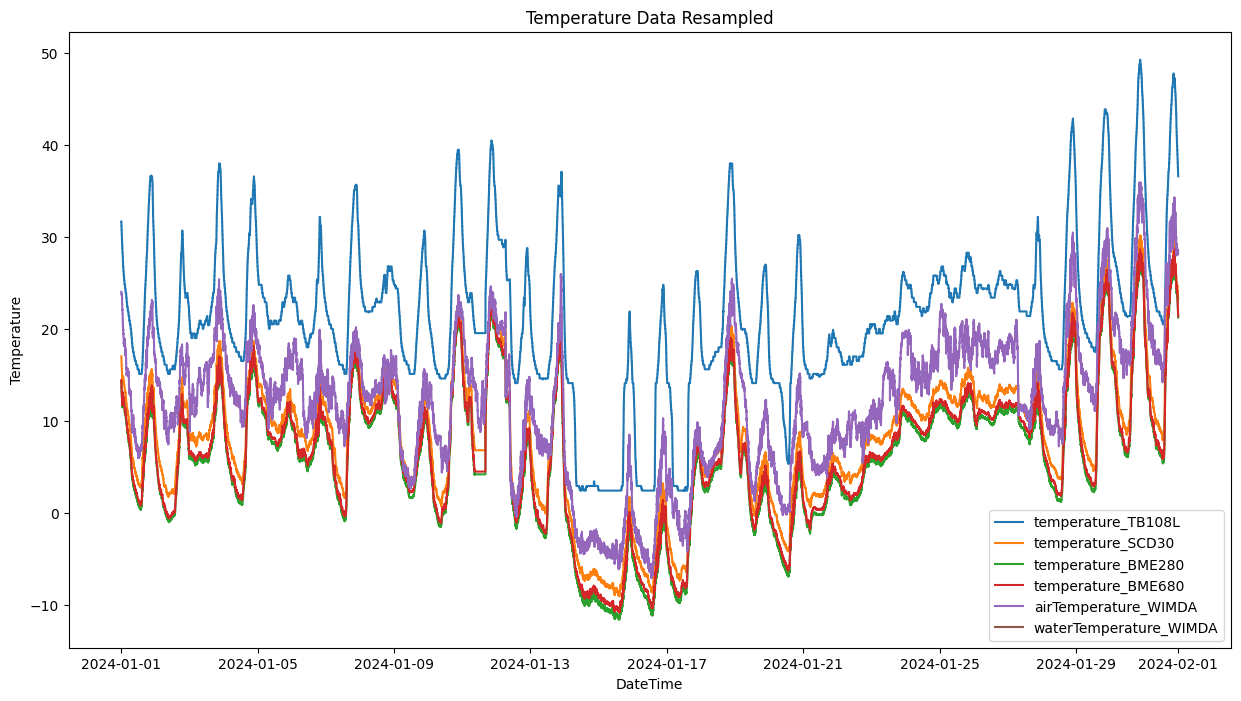

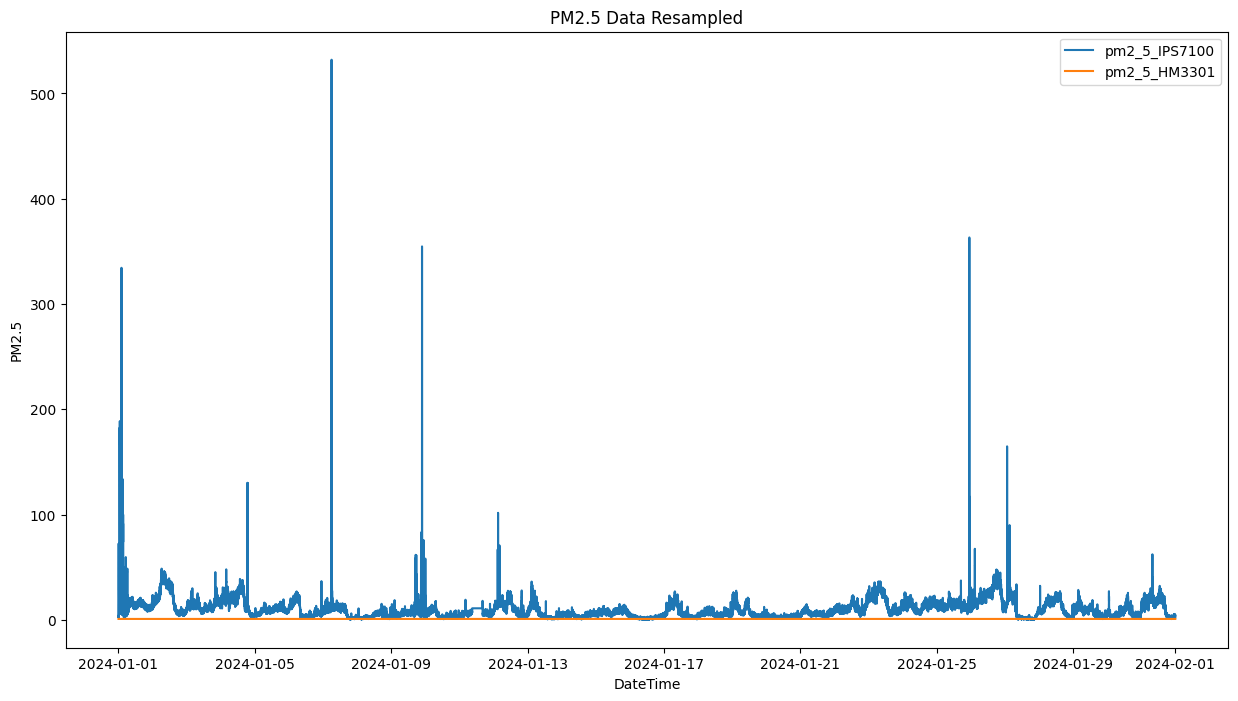

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os

def process_csv_files(yaml_file, base_folder):
    with open(yaml_file, 'r') as file:
        yaml_data = yaml.safe_load(file)

    node_ids = yaml_data['node_ids']
    sensor_ids = yaml_data['sensor_ids']

    combined_dataframes = []

    for root, dirs, files in os.walk(base_folder):
        for file in files:
            if file.endswith(".csv"):
                for node_id in node_ids:
                    for sensor_id in sensor_ids:
                        if f"MINTS_{node_id}_{sensor_id}_" in file:
                            file_path = os.path.join(root, file)

                            df = pd.read_csv(file_path)
                            df['dateTime'] = pd.to_datetime(df['dateTime'], errors='coerce')
                            df.set_index('dateTime', inplace=True)
                            numerical_cols = df.select_dtypes(include=['number']).columns
                            df_numerical = df[numerical_cols].rename(columns=lambda x: f"{x}_{sensor_id}")
                            df_resampled = df_numerical.resample('min').mean()  # Downsample to 1 minute intervals

                            # Filter temperature and PM2.5 columns
                            relevant_cols = [col for col in df_resampled.columns if 'temperature' in col.lower() or 'pm2_5' in col.lower()]
                            if relevant_cols:
                                df_relevant = df_resampled[relevant_cols]
                                combined_dataframes.append(df_relevant)

    if not combined_dataframes:
        return pd.DataFrame()

    combined_dataframe = pd.concat(combined_dataframes, axis=0).sort_index()
    combined_dataframe.ffill(inplace=True)

    return combined_dataframe

# Usage
yaml_file = '/Users/matthewlary/Desktop/Programming/Repos/sensor_calibration/SensorDataV2.yaml'
base_folder = '/Users/matthewlary/Desktop/sensorData'

# Process the CSV files and get the combined dataframe
combined_dataframe = process_csv_files(yaml_file, base_folder)

# Display the first 20 rows of the combined dataframe
pd.set_option('display.max_columns', None)  # Display all columns
print("First 20 rows of the combined dataframe:")
print(combined_dataframe.head(20))

# Plotting
if not combined_dataframe.empty:
    # Plot all temperature columns
    plt.figure(figsize=(15, 8))
    temp_columns_to_plot = [col for col in combined_dataframe.columns if 'temperature' in col.lower()]
    for column in temp_columns_to_plot:
        plt.plot(combined_dataframe.index, combined_dataframe[column], label=column)
    plt.xlabel('DateTime')
    plt.ylabel('Temperature')
    plt.title('Temperature Data Resampled')
    plt.legend()
    plt.show()
    
    # Plot all PM2.5 columns
    plt.figure(figsize=(15, 8))
    pm_columns_to_plot = [col for col in combined_dataframe.columns if 'pm2_5' in col.lower()]
    for column in pm_columns_to_plot:
        plt.plot(combined_dataframe.index, combined_dataframe[column], label=column)
    plt.xlabel('DateTime')
    plt.ylabel('PM2.5')
    plt.title('PM2.5 Data Resampled')
    plt.legend()
    plt.show()
else:
    print("Data is empty or required columns are missing.")


In [ ]:
# Graph all data instead of 1 month
# The target variable for the first analysis is winmda air temperature (use temperature, pressure, humidity all from the bme280 to try and predict temperature)
# Use the entire dataset for training (dont split up into testing and training for now)
# Think of different types of analysis that could be performed using this data from these 2 nodes
# Two weeks from now
# Plot resample and train data for pressure and humidity as well